# Neural Network for predicting stresses in thick cylinders

Stresses in a thick walled pressure vessel (whose diameter/thickness < 20) are non-linear functions of the thickness of the pressure vessel (PV), the internal and external pressure applied on the walls. These cannot be readily predicting using Linear Regression unless the features are cleverly chosen so as to resemble the analytical formula for calculating the stresses. This iPython script creates a Neural Network to predict the stresess in the cylinder.

The stresses to be predicted are the circumferential and radial stresses. These stresses can be analytically calculated using [Lame's equations](https://www.engineeringtoolbox.com/stress-thick-walled-tube-d_949.html 'Engineering Toolbox'). These stresses (the output variables) vary with the internal and external pressures and the inner and outer diameters (the input variables) of the cylindrical PV. A [Python script](https://github.com/kavanshah1197/Thick_walled_PV/blob/master/generate_PV_data.ipynb 'Github code file') permutes the input variables and uses Lame's equations to calculate the output variables. This set of inputs and outputs constitutes the training data for our Neural Network.

*Note that this is a toy problem undertaken to learn how to use the Keras API to solve Regression problems*

In [1]:
import pandas as pd
import numpy as np
import math
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

### Importing and normalizing the data
The data generated using the [Python script](https://github.com/kavanshah1197/Thick_walled_PV/blob/master/generate_PV_data.ipynb 'Github code file') is saved to a csv file called 'PV_data.csv'. The data is imported as a numpy array and split into a training set and development (a.k.a validation set). The input variables are normalized to have mean 0 and standard variance. 

In [2]:
PV_data = pd.read_csv('PV_data.csv', header=None).to_numpy()
input_data = PV_data[0:4, :]
output_data = PV_data[4:6, :]

input_obs = input_data.shape[1]
train_dev_split = 0.75
training_obs = math.floor(train_dev_split*input_obs)
dev_obs = math.floor((1-train_dev_split)*input_obs)

np.random.seed(42)
random_seq = np.random.permutation(input_obs)

training_data_input = input_data[:,random_seq[0:training_obs]]
training_data_input_mean = np.mean(training_data_input, axis = 1, keepdims=True)
training_data_input_std = np.std(training_data_input, axis = 1, keepdims=True)
training_data_input = (training_data_input-training_data_input_mean)/training_data_input_std
training_data_output = output_data[:,random_seq[0:training_obs]]

dev_data_input = input_data[:,random_seq[training_obs:]]
dev_data_input = (dev_data_input-training_data_input_mean)/training_data_input_std
dev_data_output = output_data[:,random_seq[training_obs:]]


### Building the model
A Sequential model is chosen due to the simplicity of the problem. 4 hidden layers with a ReLU activation function connect the input data to the 2 linear output units (representing the output data). The layers are densely connected. The model is summarized next.

In [3]:
stress_pred_model = Sequential()
stress_pred_model.add(Dense(32, input_shape=(4,), activation='relu'))
stress_pred_model.add(Dense(32, activation='relu'))
stress_pred_model.add(Dense(32, activation='relu'))
stress_pred_model.add(Dense(32, activation='relu'))
stress_pred_model.add(Dense(2))
stress_pred_model.summary()

initial_weights = stress_pred_model.get_weights()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                160       
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 66        
Total params: 3,394
Trainable params: 3,394
Non-trainable params: 0
_________________________________________________________________


### Model compilation and training
The Adam optimizer is used with default /beta parameters, however a non-default learning rate is chosen. The loss is mean squared error which is appropriate for the regression problem at hand. The model is trained for 1000 epochs with a batch size of 64 (These hyperparameters were tuned by trial and error. Smaller batch sizes lead to an oscillating training loss function. The loss plateaus after 1000 epochs). Validation data is fed to the model to track validation metrics.

In [4]:
opt = tf.keras.optimizers.Adam(learning_rate=0.025)
stress_pred_model.compile(optimizer=opt, loss=tf.keras.losses.MeanSquaredError())

In [5]:
hist_obj = stress_pred_model.fit(training_data_input.T, training_data_output.T, epochs=1000, verbose=0, batch_size = 64, validation_data=(dev_data_input.T, dev_data_output.T))

### Diagnostics
- Is the model overfitting the training data?
- Will getting more data improve model performance?
- Can the model extrapolate with 'sufficient' accuracy?

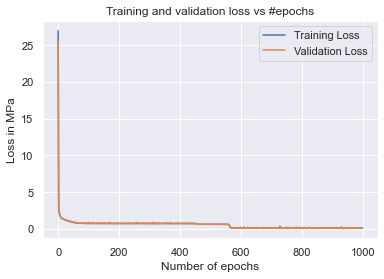

In [6]:
plt.plot(np.sqrt(hist_obj.history['loss'])/1e6, label='Training Loss')
plt.plot(np.sqrt(hist_obj.history['val_loss'])/1e6, label='Validation Loss')
plt.xlabel('Number of epochs')
plt.ylabel('Loss in MPa')
plt.title('Training and validation loss vs #epochs')
plt.legend()
plt.show()

In [7]:
print('Training Loss = ' + str(np.sqrt(hist_obj.history['loss'][-1])/1e6) + ' MPa')
print('Validation Loss = ' + str(np.sqrt(hist_obj.history['val_loss'][-1])/1e6) + ' MPa')

Training Loss = 0.152023152762992 MPa
Validation Loss = 0.11832071291198341 MPa


In [8]:
compare = stress_pred_model.predict(training_data_input.T)
compare = np.append(compare, training_data_output.T, axis=1)

In [8]:
training_sizes = np.floor(np.arange(start=0.1, stop=1.1, step=0.1)*training_obs).astype(int)
training_loss_tracker = []
validation_loss_tracker = []

for size in training_sizes:
    training_data_input_subset = training_data_input[:, 0:size+1]
    training_data_output_subset = training_data_output[:, 0:size+1]

    stress_pred_model.set_weights(initial_weights)
    hist_obj_tspick = stress_pred_model.fit(training_data_input_subset.T, training_data_output_subset.T, epochs=500, verbose=0, batch_size = 64, validation_data=(dev_data_input.T, dev_data_output.T))
    training_loss_tracker.append(hist_obj_tspick.history['loss'][-1])
    validation_loss_tracker.append(hist_obj_tspick.history['val_loss'][-1])

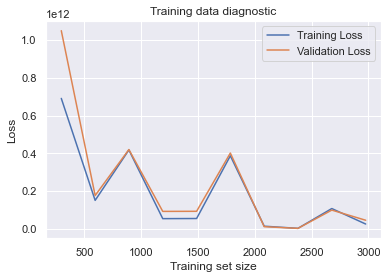

In [20]:
plt.plot(training_sizes, training_loss_tracker, label='Training Loss')
plt.plot(training_sizes, validation_loss_tracker, label='Validation Loss')
plt.xlabel('Training set size')
plt.ylabel('Loss')
plt.title('Training data diagnostic')
plt.legend()
plt.show()